# Input

This file is reading a feature file in .csv format...

# Output

It outputs exploratory plots that are save in a .pdf format; and the best model (between ridge and linear/polynomial) following the range of the degrees, ridge coefficient provided. Along with this best model, it will provide the coefficient of each features and the $R^2$ score

# Data importation

In [433]:
# Import modules
import numpy as np
import pandas as pd
import scipy
from scipy import ndimage as ndi
import seaborn as sns
import re
import warnings
import matplotlib.pyplot as plt
from skimage.measure import label
import sklearn
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.linear_model import RidgeCV, LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# https://stackoverflow.com/questions/19970764/making-feature-vector-from-gabor-filters-for-classification
# https://stackoverflow.com/questions/20608458/gabor-feature-extraction


In [434]:
TF = 'A1'
df = pd.read_csv ('../Features/TF1_'+TF+'.csv',index_col = 0)
ypet_intensity = df.copy()
ypet_intensity

,patch,img,TF_name,blur_lapl,blur_ski,patch_size,mean_intensity,sum_intensity,median_intensity,standard_deviation,...,gabro_15,lbp_0,lbp_1,lbp_2,lbp_3,lbp_4,lbp_5,lbp_6,lbp_7,Circularity
0,patch_20,1,A - 1,False,False,1648,1998.089199,3292851,1858.0,505.355583,...,0.034091,0.163976,0.157179,0.107901,0.126593,0.106202,0.107901,0.105353,0.124894,0.837007
1,patch_21,1,A - 1,False,False,1407,1637.015636,2303281,1596.0,290.282851,...,0.007212,0.234428,0.193658,0.097395,0.104190,0.066818,0.071348,0.078143,0.154020,0.824973
2,patch_22,1,A - 1,False,False,396,2425.272727,960408,2395.0,232.739898,...,0.031250,0.202847,0.192171,0.106762,0.124555,0.081851,0.064057,0.067616,0.160142,0.939736
3,patch_23,1,A - 1,False,False,222,1679.067568,372753,1470.0,547.246111,...,0.011029,0.134078,0.150838,0.134078,0.128492,0.162011,0.089385,0.078212,0.122905,0.998029
4,patch_24,1,A - 1,False,False,512,1586.785156,812434,1666.5,297.113202,...,0.027500,0.134663,0.137157,0.107232,0.147132,0.139651,0.129676,0.077307,0.127182,0.933676
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6511,patch_438,12,A - 1,False,False,1132,1106.901060,1253012,1115.0,112.664606,...,0.020313,0.208443,0.155673,0.121372,0.121372,0.087071,0.076517,0.091029,0.138522,0.850909
6512,patch_439,12,A - 1,False,False,102,970.029412,98943,971.0,109.137210,...,0.034091,0.197368,0.105263,0.171053,0.184211,0.092105,0.078947,0.092105,0.078947,0.908748
6513,patch_441,12,A - 1,False,False,1045,1114.777990,1164943,1122.0,111.621749,...,0.150735,0.212976,0.190409,0.093089,0.108604,0.081805,0.086037,0.086037,0.141044,0.763415
6514,patch_442,12,A - 1,False,False,963,1162.664590,1119646,1172.0,143.616285,...,0.008013,0.169343,0.159124,0.102190,0.119708,0.094891,0.118248,0.108029,0.128467,0.784256


# Preprocessing

## Parameters to adapt for the data processing

In [435]:
#parameters to adapt for analyzation:
#outlier removal
outlier = True             #If outliers in general should be removed True, if not False
Save = False                #Will try to save it the conditions are suitable
interquantile = True       #if outliers should be removed by defining a range with the interquantile: True; to remove outliers just when they're exceeding a certain quantile: False
quantile_keep = 0.95        #to change if interquantile = False; else ignore
outlier_columns = ['mean_intensity'] #choose columns of which the outliers should be removed. to choose all the columns: list(ypet_intensity_processed)[6:]
outlier_range = 2         #if interquantile = True defined this value to define the range. Gets multiplicated with interquantile. Else ignore
#Normalization
normalization = True
columns_to_be_normalized =  ['mean_intensity','median_intensity','sum_intensity'] #list(ypet_intensity_processed)[6:]  #if all columns should be normalized
                            #take logs to reduce skewness
take_log = False             #want to take the log of certain columns
columns_log = ['mean_intensity'] #needs pre-analyzation of columns if log is needed. With a histogram it can be seen if the distribution is skewed. 
ypet_intensity_processed = ypet_intensity.copy()


## Outlier removal in columns of the dataframe

In [436]:
def outlier_removal(without_outliers, **kwargs):
    #define input parameters
    outlier_range =   kwargs['outlier_range']
    outlier_columns = kwargs['outlier_columns'] 
    interquantile =   kwargs['interquantile']
    quantile_keep =   kwargs['interquantile']
    # first choose which method for outlier removal wants to be used. Use a for loop to iterate over the defined columns of the dataframe.
    if interquantile == True:
        for col in outlier_columns:
            # defined the interquantile range and then the upper and lower limit of the choosen column
            median = without_outliers[col].median()
            q_75 = without_outliers[col].quantile(q = 0.75)
            q_25 = without_outliers[col].quantile(q = 0.25)
            interquantile = q_75 - q_25                              
            upper_bound = median + (interquantile * outlier_range)
            lower_bound = median - (interquantile * outlier_range)

            # Create a boolean mask that is True for rows with a value less than or equal to the upper limit and higher or equal to the lower limit
            mask = (without_outliers[col] <= upper_bound) & (without_outliers[col] >= lower_bound)
            # Use the mask to filter the dataframe
            without_outliers = without_outliers[mask]
    else: 
        for col in columns_outliers:
            #define the limit up to which the values are kept
            quantile_limit = without_outliers[col].quantile(q = quantile_keep)
            #define a boolean mask that is True for rows that are in the defined limit
            mask = without_outliers[col] <= quantile_limit
            #use the mask to filter the dataframe
            without_outliers = without_outliers[mask]
        
    return without_outliers


In [437]:
#apply the function for outlier removal
if outlier == True:
    #group by the TF and just cut the outliers for one TF
    without_outliers = ypet_intensity_processed.groupby('TF_name',as_index=False).apply(outlier_removal, outlier_range=outlier_range, outlier_columns=outlier_columns, interquantile = interquantile, quantile_keep=quantile_keep).reset_index()
    #change index so dataframe is as before
    without_outliers = without_outliers.drop(['level_0'],axis=1)
    without_outliers = without_outliers.set_index('level_1')
    without_outliers.index.name = None
    #save it under a new dataframe
    ypet_intensity_processed = without_outliers.copy()

## Take logarithm of certain columns to get rid of the skewness

In [438]:
#take logs of certain columns that are skewed
if take_log == True:
    TF_grouped = ypet_intensity_processed.groupby('TF_name')
    log_rows = TF_grouped[columns_log].transform(lambda x: np.log(x))
    ypet_intensity_processed[columns_log] = log_rows 

## Normalization of columns of the dataframe

In [439]:
# Normalization of columns of the dataframe
if normalization == True:
    TF_grouped = ypet_intensity_processed.groupby('TF_name')
    Normalized_columns = TF_grouped[columns_to_be_normalized].transform(lambda x: (x - x.mean()) / x.std()) #removed rows_to_be to have all col normalized

    # Replace normalized
    ypet_intensity_processed[columns_to_be_normalized] = Normalized_columns                         


# Task 1

In [440]:
print(list(ypet_intensity_processed))

['patch', 'img', 'TF_name', 'blur_lapl', 'blur_ski', 'patch_size', 'mean_intensity', 'sum_intensity', 'median_intensity', 'standard_deviation', 'variance', 'skewness', 'kurtosis', 'interquartile_range ', 'entropy', 'Perimeter', 'area_Test', 'axis_major_length', 'feret_diameter_max', 'axis_minor_length', 'solidity', 'similarity', 'hull area', 'correlation coef', 'gabro_0', 'gabro_1', 'gabro_2', 'gabro_3', 'gabro_4', 'gabro_5', 'gabro_6', 'gabro_7', 'gabro_8', 'gabro_9', 'gabro_10', 'gabro_11', 'gabro_12', 'gabro_13', 'gabro_14', 'gabro_15', 'lbp_0', 'lbp_1', 'lbp_2', 'lbp_3', 'lbp_4', 'lbp_5', 'lbp_6', 'lbp_7', 'Circularity']


# Data exploration

## Scatterplots of different parameters compared to each other

Scatterplots (if you want with regression line (degree 1))

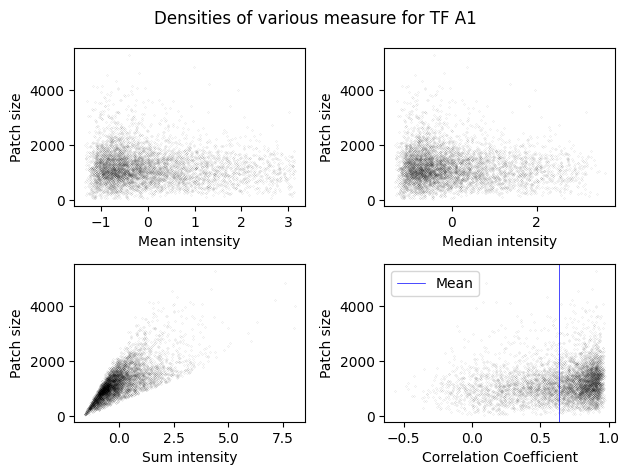

In [441]:
mk_size = 0.01 #Choose a small mk_size if a lot of datapoints, so densities are easier to read
points_col = 'black'
line_col   = 'blue'

plt.figure()
plt.subplot(221)
sns.regplot(y="patch_size", x="mean_intensity", data=ypet_intensity_processed,marker = '.',scatter_kws={'s':mk_size}, color = points_col, fit_reg=False)
plt.xlabel("Mean intensity"); plt.ylabel("Patch size")
plt.subplot(222)
sns.regplot(y="patch_size", x="median_intensity", data=ypet_intensity_processed,marker = '.',scatter_kws={'s':mk_size}, color = points_col, fit_reg=False)
plt.xlabel("Median intensity"); plt.ylabel("Patch size")
plt.subplot(223)
sns.regplot(y="patch_size", x="sum_intensity", data=ypet_intensity_processed,marker = '.',scatter_kws={'s':mk_size}, color = points_col, fit_reg=False)
plt.xlabel("Sum intensity"); plt.ylabel("Patch size")
plt.subplot(224)
sns.regplot(y="patch_size", x="correlation coef", data=ypet_intensity_processed,marker = '.',scatter_kws={'s':mk_size}, color = points_col, fit_reg=False)
plt.xlabel("Correlation Coefficient"); plt.ylabel("Patch size")
plt.axvline(np.mean(ypet_intensity_processed['correlation coef']),color = line_col,linewidth = 0.5,label = "Mean")
plt.legend()
plt.suptitle("Densities of various measure for TF "+TF)
plt.tight_layout()
if Save:
    plt.savefig("../Images/task1/densities_"+TF+".pdf")
plt.show()

## Parameters to define

In [442]:
maxdegree = 10                          #To define is the maximum degree of the polynomial that should be tried (maxdegree of 5 takes degree up to 4 into account)
x_features = ['mean_intensity','sum_intensity','correlation coef','median_intensity'] #define a list with all the columns that could be interesting for task 1
decide_x_features = np.array([1])      #set the list of indexes for the X values used for regression from list defined in test_features
decide_y_feature = 'patch_size'        #also other features could be taken into account


## Prepare test and train sets and X and y

In [443]:
#Define features used with the right format, following x_features and decide_x_features
features_used = [x_features[i] for i in decide_x_features]

# Split in train and test set
df_train, df_test = train_test_split(ypet_intensity_processed, train_size = 0.8, test_size = 0.2, random_state = 10)

#define the x and the y for the test and train sets
df_train_x = df_train[features_used]
df_test_x = df_test[features_used]

df_train_y = df_train[[decide_y_feature]]
df_test_y = df_test[[decide_y_feature]]

## Apply cross validation

In [444]:
#model to select
cross_validation_ridge_error = np.zeros(maxdegree)
cross_validation_lm_error = np.zeros(maxdegree)

#see which degree fits data the best for linear regression
for d in range(1, maxdegree+1):    #it will create 1,2...maxdregree range vector like this
    #polynomial feature expansion of x_train
    x_poly_train = PolynomialFeatures(degree=d).fit_transform(df_train_x)
    #apply linear regression model and cross-validation for alpha-ridge regression
    lr = LinearRegression()
    rr = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1])
    #apply cross validation
    cve = cross_validate(lr,x_poly_train,df_train_y,scoring='neg_mean_squared_error', cv=5, return_train_score=True)
    crr = cross_validate(rr,x_poly_train,df_train_y,scoring='neg_mean_squared_error', cv=5, return_train_score=True)
    #make array for cross validation with linear model and for ridge regression
    cross_validation_lm_error[d-1] = np.mean(np.absolute(cve['test_score']))
    cross_validation_ridge_error[d-1] = np.mean(np.absolute(crr['test_score']))

## Choose best model

In [445]:
index_min_lm = np.argmin(cross_validation_lm_error)
index_min_ridge = np.argmin(cross_validation_ridge_error)

poly_lm_test = PolynomialFeatures(degree=index_min_lm+1)
x_poly_test_lm = poly_lm_test.fit_transform(df_test_x)
poly_lm_train = PolynomialFeatures(degree=index_min_lm+1)
x_poly_train_lm = poly_lm_train.fit_transform(df_train_x)

x_poly_train_df_lm = pd.DataFrame(x_poly_train_lm)
x_poly_test_df_lm = pd.DataFrame(x_poly_test_lm)

poly_ridge_test = PolynomialFeatures(degree=index_min_ridge+1)
x_poly_test_ridge = poly_ridge_test.fit_transform(df_test_x)
poly_ridge_train = PolynomialFeatures(degree=index_min_ridge+1)
x_poly_train_ridge = poly_ridge_train.fit_transform(df_train_x)

x_poly_train_df_ridge = pd.DataFrame(x_poly_train_ridge)
x_poly_test_df_ridge = pd.DataFrame(x_poly_test_ridge)

#make linear model
model_lm = LinearRegression().fit(x_poly_train_df_lm, df_train_y)
model_ridge = RidgeCV(alphas=[1e-4,1e-3, 1e-2, 1e-1, 1]).fit(x_poly_train_df_ridge, df_train_y)

#train error
y_train_pred_lm = model_lm.predict(x_poly_train_lm)
mse_train_lm = mean_squared_error(df_train_y,y_train_pred_lm)
y_train_pred_ridge = model_ridge.predict(x_poly_train_ridge)
mse_train_ridge = mean_squared_error(df_train_y,y_train_pred_ridge)

#test error
y_test_pred_lm = model_lm.predict(x_poly_test_df_lm)
mse_test_lm = mean_squared_error(df_test_y,y_test_pred_lm)
y_test_pred_ridge = model_ridge.predict(x_poly_test_df_ridge)
mse_test_ridge = mean_squared_error(df_test_y,y_test_pred_ridge)

## Visualize the best model and give back the parameters

In [446]:
df_plot_sort = pd.DataFrame(df_test_x)
df_plot_sort['reg'] =  y_test_pred_lm[:,0]
df_plot_sort.sort_values(features_used[0],inplace = True)

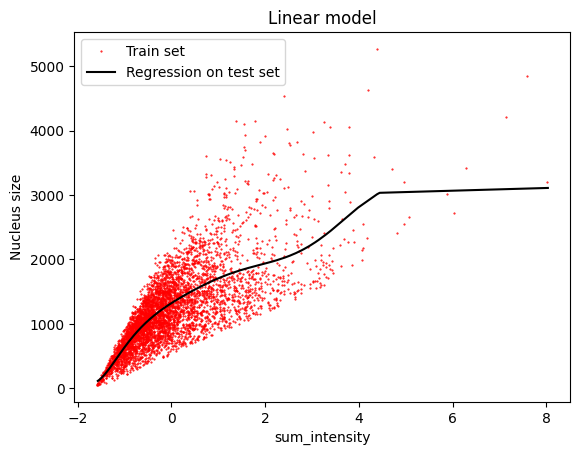

' OLD WAY TO PLOT IT (if need to go back)\n#show predicted points with linear model\nplt.plot(df_train_x,df_train_y, \'ro\')\nplt.plot(df_test_x,y_test_pred_lm, \'o\',color = \'black\')\n#plt.yscale("log")\n#plt.xscale("log")\nplt.show()\n'

In [447]:
#show predicted points with linear model

if (len(features_used)!=1):
    warnings.warn("WARNING features_used should be of len 1 for this plot")
else:
    plt.figure()
    plt.plot(df_train_x,df_train_y, 'r.',markersize = 1,label = "Train set")
    plt.plot(df_plot_sort[features_used[0]],df_plot_sort['reg'],color = 'black',label = "Regression on test set")
    plt.ylabel("Nucleus size")
    plt.xlabel(features_used[0])    #WARNING features_used should be of len 1 for this plot
    plt.title("Linear model")
    plt.legend()
    #plt.yscale("log")
    #plt.xscale("log")
    if Save:
        plt.savefig("../Images/task1/linear_model_"+features_used[0]+"_"+TF+".pdf") 
    plt.show()


''' OLD WAY TO PLOT IT (if need to go back)
#show predicted points with linear model
plt.plot(df_train_x,df_train_y, 'ro')
plt.plot(df_test_x,y_test_pred_lm, 'o',color = 'black')
#plt.yscale("log")
#plt.xscale("log")
plt.show()
'''

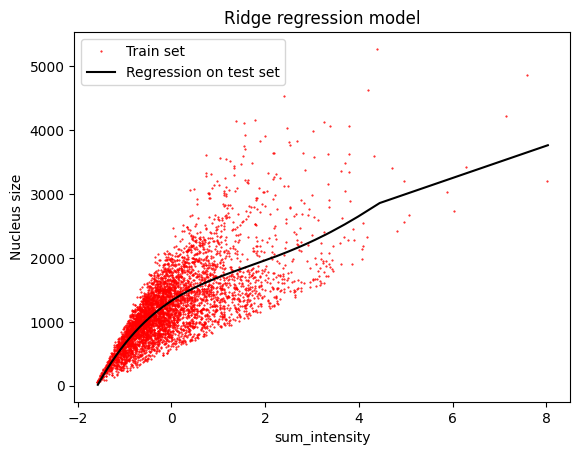

' OLD WAY TO PLOT IT (if need to go back)\n#show predicted points with ridge regression\nplt.plot(df_train_x,df_train_y, \'ro\')\nplt.plot(df_test_x,y_test_pred_ridge, \'o\',color = \'black\')\n#plt.yscale("log")\n#plt.xscale("log")\nplt.show()\n'

In [448]:
#show predicted points with linear model
df_plot_sort_ridge = pd.DataFrame(df_test_x)
df_plot_sort_ridge['reg'] =  y_test_pred_ridge[:,0]
df_plot_sort_ridge.sort_values(features_used[0],inplace = True)

if (len(features_used)!=1):
    warnings.warn("WARNING features_used should be of len 1 for this plot")
else:
    plt.figure()
    plt.plot(df_train_x,df_train_y, 'r.',markersize = 1,label = "Train set")
    plt.plot(df_plot_sort_ridge[features_used[0]],df_plot_sort_ridge['reg'],color = 'black',label = "Regression on test set")
    plt.ylabel("Nucleus size")
    plt.xlabel(features_used[0])    #WARNING features_used should be of len 1 for this plot
    plt.title("Ridge regression model")
    plt.legend()
    #plt.yscale("log")
    #plt.xscale("log")
    if Save:
        plt.savefig("../Images/task1/ridge_model_"+features_used[0]+"_"+TF+".pdf")
    plt.show()

''' OLD WAY TO PLOT IT (if need to go back)
#show predicted points with ridge regression
plt.plot(df_train_x,df_train_y, 'ro')
plt.plot(df_test_x,y_test_pred_ridge, 'o',color = 'black')
#plt.yscale("log")
#plt.xscale("log")
plt.show()
'''


## Output of the coefficients 

In [449]:
if mse_test_ridge >= mse_test_lm:
    feature_names = poly_lm_test.get_feature_names_out(input_features=features_used)
    print('take linear regression')
    print('features: ',feature_names)
    print('coefficients: ',model_lm.coef_)
    print('intercept: ',model_lm.intercept_)
    print('R^2-score: ', r2_score(df_train_y,y_train_pred_lm))
    

else:
    feature_names = poly_ridge_test.get_feature_names_out(input_features=features_used)
    print('take ridge regression')
    print('features: ',feature_names)
    print('coefficients: ',model_ridge.coef_)
    print('intercept: ',model_ridge.intercept_)
    print('alpha: ',model_ridge.alpha_)
    print('R^2-score: ', r2_score(df_train_y,y_train_pred_ridge))

take ridge regression
features:  ['1' 'sum_intensity' 'sum_intensity^2' 'sum_intensity^3' 'sum_intensity^4']
coefficients:  [[   0.          482.48729233 -153.17573058   41.33441834   -3.117968  ]]
intercept:  [1326.38467399]
alpha:  1.0
R^2-score:  0.5686804656312803
